# testing the orientation component

On this page, we concerntrate on the orientation variable and test the effect of changing the average orientation as well as the bandwidth.

In [1]:
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import pylab
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import MotionClouds as mc
import os
fx, fy, ft = mc.get_grids(mc.N_X, mc.N_Y, mc.N_frame)
help(mc.envelope_orientation)

Help on function envelope_orientation in module MotionClouds:

envelope_orientation(fx, fy, ft, theta=0.0, B_theta=0.19634954084936207)
    Returns the orientation envelope:
    We use a von-Mises distribution on the orientation:
    - mean orientation is ``theta`` (in radians),
    - ``B_theta`` is the bandwidth (in radians). It is equal to the standard deviation of the Gaussian
    envelope which approximate the distribution for low bandwidths. The Half-Width at Half Height is
    given by approximately np.sqrt(2*B_theta_**2*np.log(2)).
    
    Run 'testing-grating.py' notebook to see the effect of changing theta and B_theta, see
    http://motionclouds.invibe.net/posts/testing-grating.html



In [3]:
name = 'grating'
#initialize
fx, fy, ft = mc.get_grids(mc.N_X, mc.N_Y, mc.N_frame)

z = mc.envelope_gabor(fx, fy, ft)
mc.figures(z, name, vext='.gif')
mc.figures(z, name)
mc.in_show_video(name)

In [4]:
# explore parameters
for sigma_div in [1, 2, 3, 5, 8, 13 ]:
    name_ = name + '-largeband-B_theta-pi-over-' + str(sigma_div).replace('.', '_')
    z = mc.envelope_gabor(fx, fy, ft, B_theta=np.pi/sigma_div)
    mc.figures(z, name_)
    mc.in_show_video(name_)

In [5]:
for div in [1, 2, 4, 3, 5, 8, 13, 20, 30]:
    name_ = name + '-theta-pi-over-' + str(div).replace('.', '_')
    z = mc.envelope_gabor(fx, fy, ft, theta=np.pi/div)
    mc.figures(z, name_)
    mc.in_show_video(name_)

In [6]:
V_X = 1.0
for sigma_div in [1, 2, 3, 5, 8, 13 ]:
    name_ = name + '-B_theta-pi-over-' + str(sigma_div).replace('.', '_') + '-V_X-' + str(V_X).replace('.', '_')
    z = mc.envelope_gabor(fx, fy, ft, V_X=V_X, B_theta=np.pi/sigma_div)
    mc.figures(z, name_)
    mc.in_show_video(name_)

In [7]:
for B_sf in [0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.8]:
    name_ = name + '-B_sf-' + str(B_sf).replace('.', '_')
    z = mc.envelope_gabor(fx, fy, ft, B_sf=B_sf)
    mc.figures(z, name_)
    mc.in_show_video(name_)

## tuning the bandwidth

In the ``MotionClouds`` script, we define the orientation envelope based on a VonMises distribution:

In [8]:
def vonmises(th, theta, kappa, norm=True):
    if kappa==0:
        env = np.ones_like(th) 
    elif kappa==np.inf:
        env = np.zeros_like(th)
        env[np.argmin(th < theta)] = 1.
    else:
        env = np.exp(kappa*(np.cos(2*(th-theta))-1))
    if norm:
        return env/env.sum()
    else:
        return env

This definition handles also the extreme cases when the bandwidth is infinite (in which case we return a flat distribution) of null (so we get a dirac). Note also that the von Mises distribution is on a continuous variable (orientation), while we use a discrete fourier transform. In particular, some care should be taken for very narrow bandwidths.

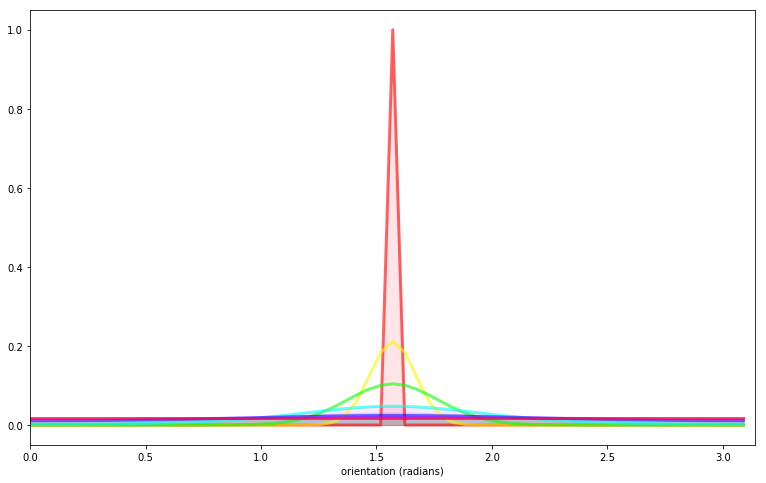

In [9]:
N_theta = 16
theta, B_sf, B_V = np.pi/2, .1, .3
bins = 60
th = np.linspace(0, np.pi, bins, endpoint=False)
fig, ax = plt.subplots(1, 1, figsize=(13, 8))
B_theta_ = [np.pi/640, np.pi/32, np.pi/16, np.pi/8, np.pi/4, np.pi/2, np.inf]
for B_theta, color in zip(B_theta_, [plt.cm.hsv(h) for h in np.linspace(0, 1, len(B_theta_))]):
    kappa = 1./4/B_theta**2
    ax.plot(th, vonmises(th, theta, kappa), alpha=.6, color=color, lw=3)
    ax.fill_between(th, 0, vonmises(th, theta, B_theta), alpha=.1, color=color)
    ax.set_xlabel('orientation (radians)')
_ = ax.set_xlim([0, np.pi])

Getting everything peaking at one:

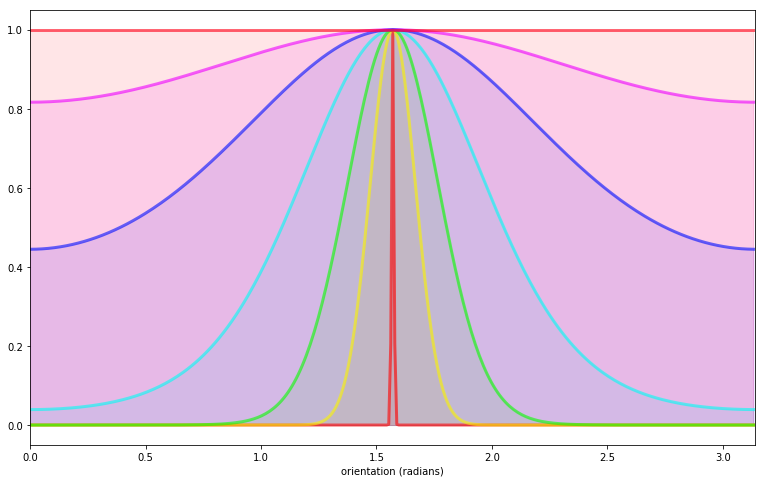

In [10]:
N_theta = 16
theta, B_sf, B_V = np.pi/2, .1, .3
bins = 360
th = np.linspace(0, np.pi, bins, endpoint=False)
fig, ax = plt.subplots(1, 1, figsize=(13, 8))
for B_theta, color in zip(B_theta_, [plt.cm.hsv(h) for h in np.linspace(0, 1, len(B_theta_))]):
    kappa = 1./4/B_theta**2
    ax.plot(th, vonmises(th, theta, kappa, norm=False), alpha=.6, color=color, lw=3)
    ax.fill_between(th, 0, vonmises(th, theta, kappa, norm=False), alpha=.1, color=color)
    ax.set_xlabel('orientation (radians)')
_ = ax.set_xlim([0, np.pi])

Let's check that the HWHH (half-width at half-height) is given by the bandwidth parameter ``B_theta``. Note that for high values of ``B_theta``, the minimum of the distribution may be higher than 1/2 and that this decriptive value may be ill-defined (see for instance [Swindale, N. V. (1998). Orientation tuning curves: empirical description and estimation of parameters. Biological Cybernetics, 78(1):45-56.](http://www.citeulike.org/user/LaurentPerrinet/article/8501521)). We will use the broader definition by using the fully normalized von mises that peaks at one and with a minimum at 0 : 
$$M(\theta) = \frac {\exp( \kappa \cdot cos(2\theta)) - \exp( -\kappa) }{\exp(\kappa) - \exp( -\kappa) }$$
The different expression for the HWHH are for the Gaussian approximation:
$$\theta_{HWHH} = \sqrt{2\ln(2)} \cdot \kappa $$
for the non-normalized von-Mises pdf (as in Swindale):
$$\theta_{HWHH} = \frac 1 2 \cdot \arccos (1 + \frac{\kappa - \ln(2)}{\kappa})$$for the normalized (exact) solution:
$$\theta_{HWHH} = \frac 1 2 \cdot \arccos (1 + \frac{\ln(\frac{1+e^{-2\kappa})}{2}}{\kappa})$$

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in arccos


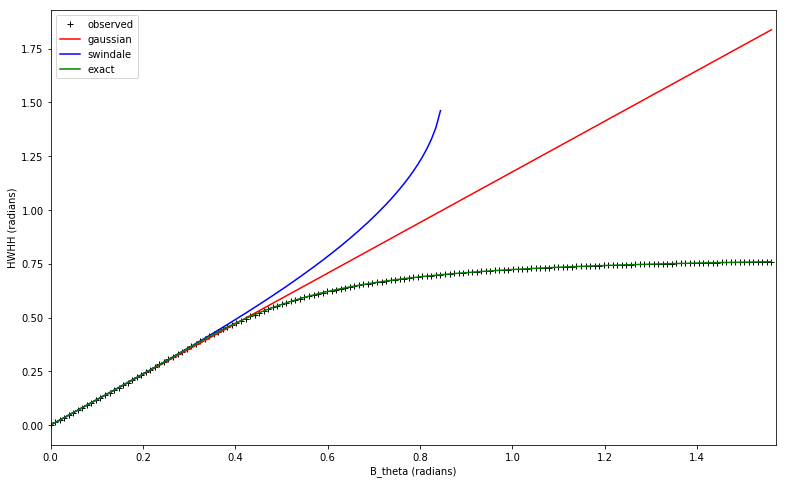

In [11]:
N_theta = 160
theta, B_sf, B_V = 0, .1, .3
B_theta_ = np.linspace(0, np.pi/2, N_theta, endpoint=False)
bins = 3600
th = np.linspace(0, np.pi, bins, endpoint=False)
HWHH = np.zeros(N_theta)
for _, B_theta in enumerate(B_theta_):
    kappa = 1./4/B_theta**2
    dist = vonmises(th, theta, kappa)
    dist = (dist - dist.min())/(dist.max() - dist.min())
    ind_HWHH = np.argmax(dist<.5)
    HWHH[_] = th[ind_HWHH]
fig, ax = plt.subplots(1, 1, figsize=(13, 8))
ax.plot(B_theta_, HWHH, 'k+', label='observed')
ax.plot(B_theta_, B_theta_*np.sqrt(2*np.log(2)), 'r', label='gaussian')
k= 1./4/B_theta_**2
ax.plot(B_theta_, .5*np.arccos((-np.log(2)+k)/k), 'b', label='swindale')
ax.plot(B_theta_, .5*np.arccos(1+ np.log((1+np.exp(-2*k))/2)/k), 'g', label='exact')
ax.set_xlabel('B_theta (radians)')
ax.set_ylabel('HWHH (radians)')
ax.legend()
_ = ax.set_xlim([0, np.pi/2])

This shows that in the range of relevant values of ``B_theta`` (that is inferior to approximately 60 degrees) we can control the bandwidth as for a Gaussian or a von-Mises curve, while for higher values, the distribution can be considered to be flat.